# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 🔧🗃️ETL Code of the "🏞️Catalonia Water Resource Daily Monitoring🚰" Dataset</div>

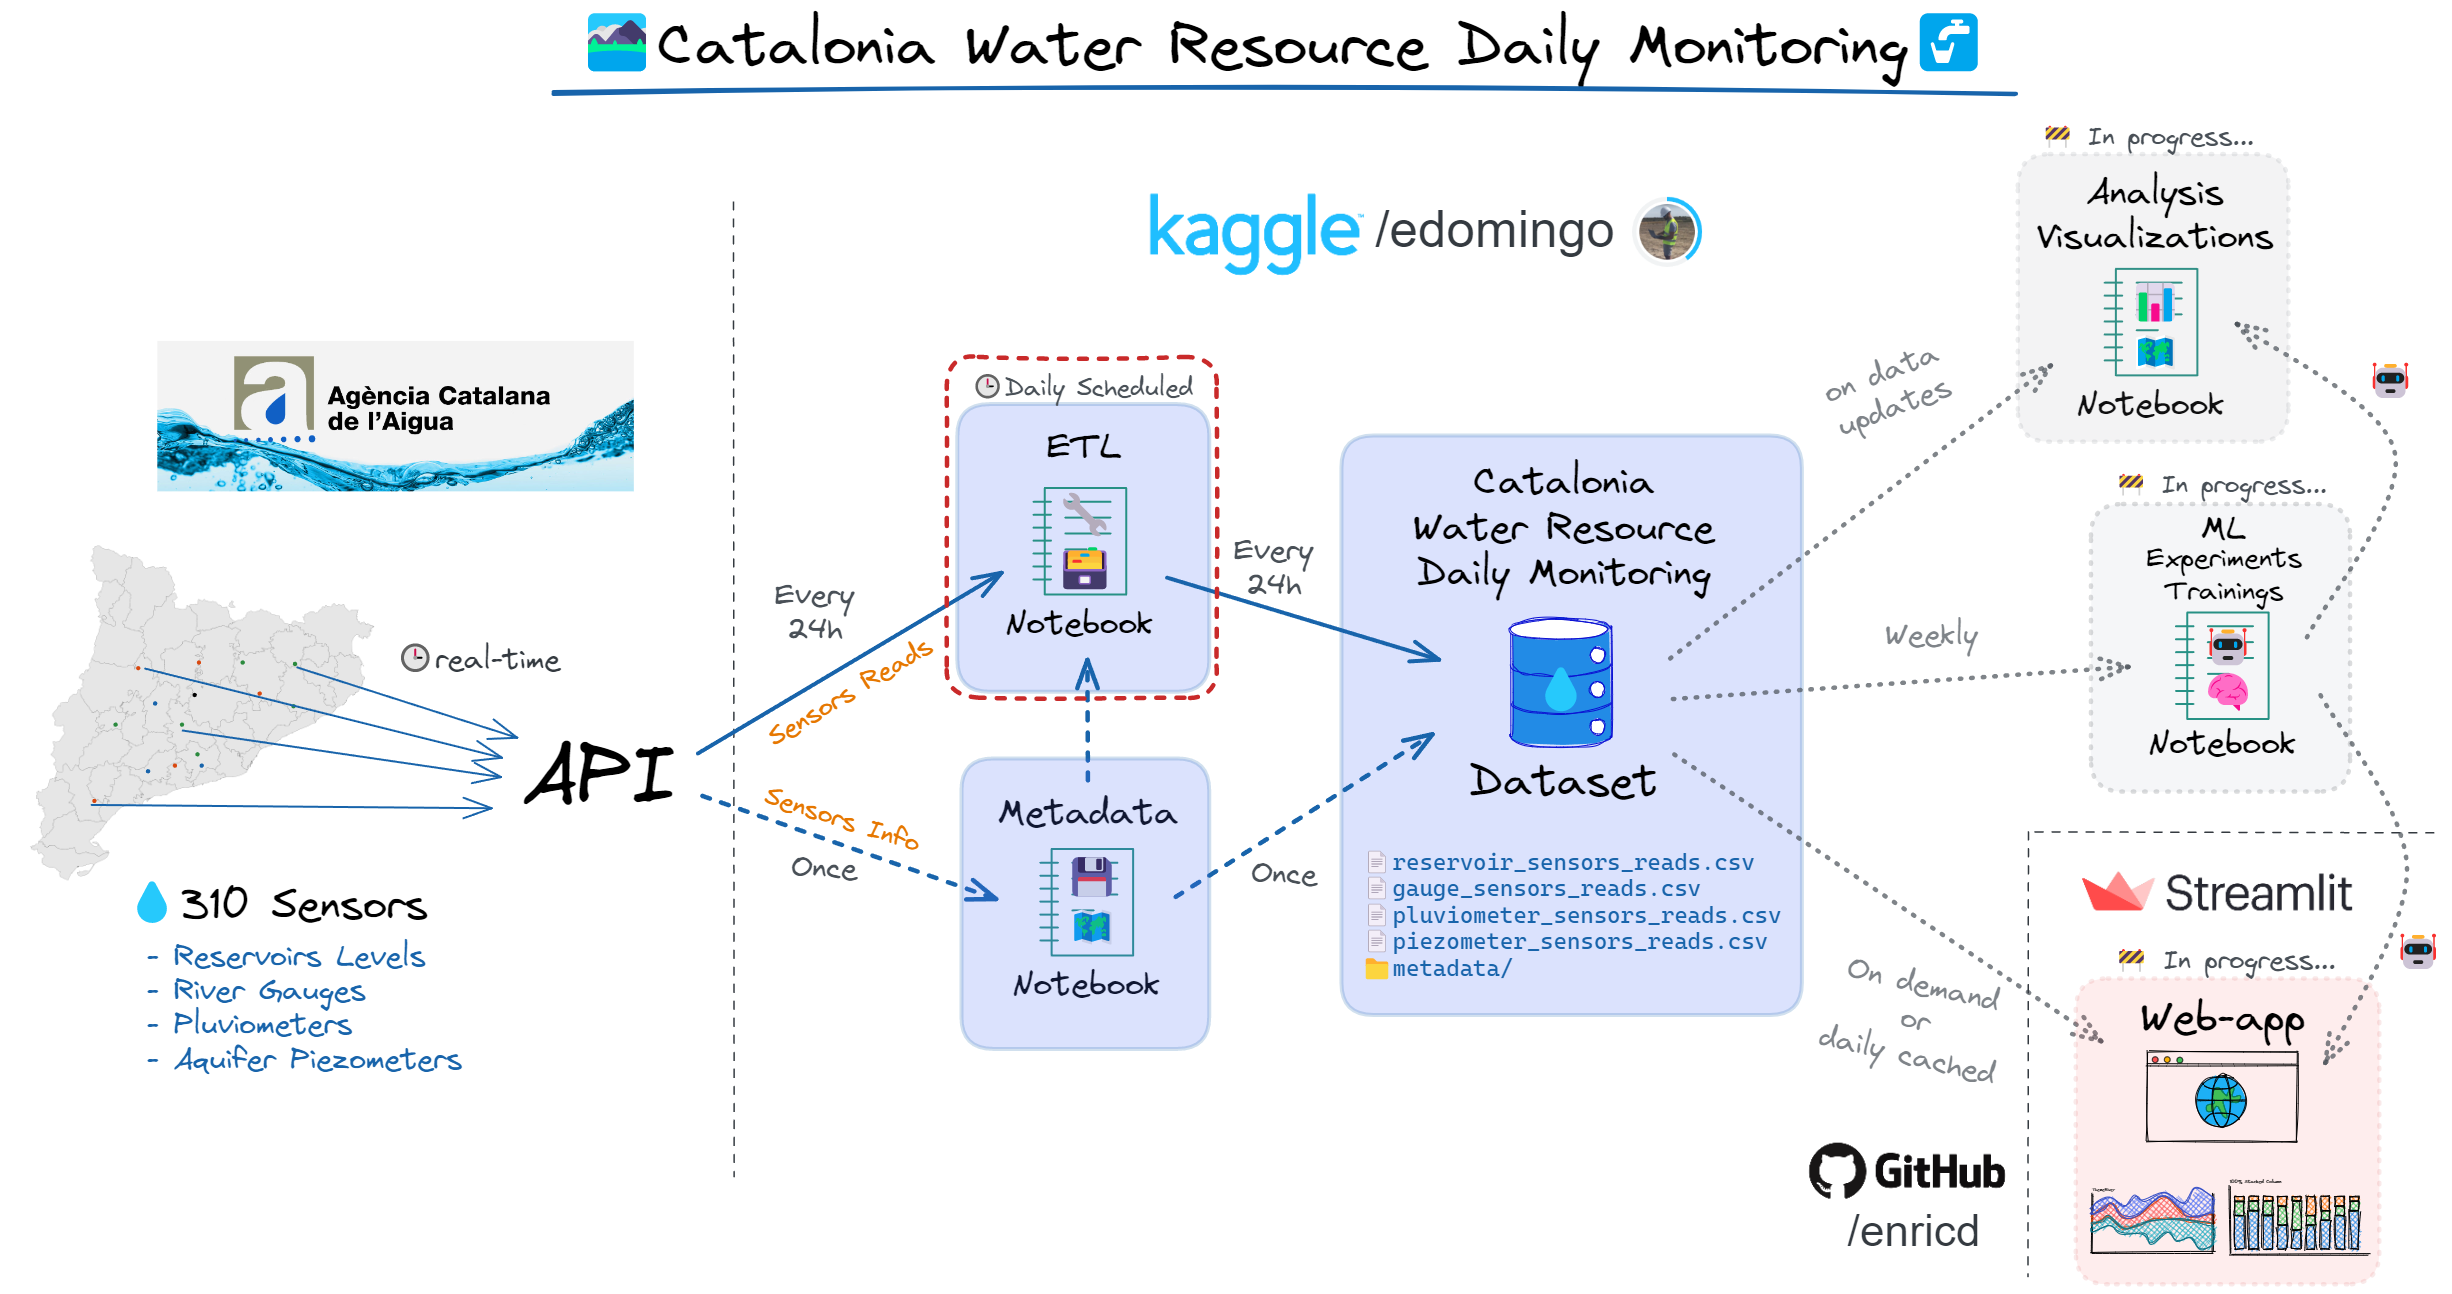

This is an **ETL (Extract, Transform and Load)** Kaggle Notebook, **scheduled** to run automatically on a **daily** basis, in order to extract information from the public API of the [ACA - Agència Catalana de l'Aigua](https://aca.gencat.cat/) (Catalan Water Agency). This API contains the **real-time value reads from 4 types of sensors** (Reservoir Level Sensors, Gauging Sensors, Pluviometer Sensors, and Piezometer Sensors) placed around the Catalan region in Spain. It also contains Metadata information which is extracted and saved in another supplementary Notebook, and later imported here.

### Dataset Motivation and Context:

In Catalonia, we are currently experiencing a dry period, characterized by reduced precipitation and lower-than-average water levels in reservoirs and rivers as well as in other regions. It's not summer yet and we are already struggling in our water reserve levels, for this reason the local authorities are starting to plan a set of actions (e.g. water supply reductions/cuts) in the following months. Gathering this data, starting from early January and continuosly updating it day by day, will be a great source for further real-time Analysis of the situation, Visualizations of trends, and even the possibility to build short term Prediction Models.

### Consider leaving an upvote to: 
- this 🔧🗃️ETL Notebook
- the [💾Metadata extraction Notebook](https://www.kaggle.com/code/edomingo/metadata-cat-water-resource-monitoring) 
- the [💧Catalonia Water Resource Daily Monitoring🏞️ Dataset](https://www.kaggle.com/datasets/edomingo/catalonia-water-resource-daily-monitoring)  

if you found them interesting, and feel free to leave any question, suggestion or improvement in the comments. Thanks!! 🤗

# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 📋 Table of Contents</div>

* [1- Libraries](#section-1)
* [2- Sensors Metadata](#section-2)
* [3- Data **E**xtraction from ACA API and **T**ransformation](#section-3)
* [4- Data **L**oading](#section-4) 
* [5- Some Statistics](#section-5)
* [6- Changelog](#section-6) 

<a id="section-1"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 1. Libraries</div>

In [1]:
import numpy as np
import pandas as pd
import json
import requests
import os
from pathlib import Path
import datetime as dt
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

<a id="section-2"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 2. Sensors Metadata</div>

The Sensors Metadata and info is extracted from the ACA API and processed into .csv files in this separate [Notebook](https://www.kaggle.com/code/edomingo/metadata-cat-daily-water-resource-monitoring)



In [2]:
METADATA_PATH = Path("./dataset/metadata")

df_reservoir_sensors_metadata = pd.read_csv(METADATA_PATH / "reservoir_sensors_metadata.csv")
df_gauge_sensors_metadata = pd.read_csv(METADATA_PATH / "gauge_sensors_metadata.csv")
df_pluviometer_sensors_metadata = pd.read_csv(METADATA_PATH / "pluviometer_sensors_metadata.csv")
df_piezometer_sensors_metadata = pd.read_csv(METADATA_PATH / "piezometer_sensors_metadata.csv")

# Saving again the metadata files for the next version
if not os.path.exists("metadata/"):
    os.mkdir("metadata/")
    
df_reservoir_sensors_metadata.to_csv("metadata/reservoir_sensors_metadata.csv", index=False)
df_gauge_sensors_metadata.to_csv("metadata/gauge_sensors_metadata.csv", index=False)
df_pluviometer_sensors_metadata.to_csv("metadata/pluviometer_sensors_metadata.csv", index=False)
df_piezometer_sensors_metadata.to_csv("metadata/piezometer_sensors_metadata.csv", index=False)

In [3]:
reservoir_sensors_ids = df_reservoir_sensors_metadata["sensor_id"]

print("\nDescriptions:")
display(df_reservoir_sensors_metadata["description"].value_counts())
print("\nUnits:")
display(df_reservoir_sensors_metadata["unit"].value_counts())


Descriptions:


description
Absolute level                 11
Reservoir volume               11
Percentage reservoir volume    11
Name: count, dtype: int64


Units:


unit
masl    11
hm³     11
%       11
Name: count, dtype: int64

In [4]:
gauge_sensors_ids = df_gauge_sensors_metadata["sensor_id"]

print("\nDescriptions:")
display(df_gauge_sensors_metadata["description"].value_counts())
print("\nUnits:")
display(df_gauge_sensors_metadata["unit"].value_counts())


Descriptions:


description
River discharge    80
River level        74
Canal discharge    16
Total discharge     1
Name: count, dtype: int64


Units:


unit
m³/s    82
cm      74
l/s     15
Name: count, dtype: int64

In [5]:
pluviometer_sensors_ids = df_pluviometer_sensors_metadata["sensor_id"]

print("\nDescriptions:")
display(df_pluviometer_sensors_metadata["description"].value_counts())
print("\nUnits:")
display(df_pluviometer_sensors_metadata["unit"].value_counts())


Descriptions:


description
Rainfall intensity    47
Name: count, dtype: int64


Units:


unit
mm/h    47
Name: count, dtype: int64

In [6]:
piezometer_sensors_ids = df_piezometer_sensors_metadata["sensor_id"]

print("\nDescriptions:")
display(df_piezometer_sensors_metadata["description"].value_counts())
print("\nUnits:")
display(df_piezometer_sensors_metadata["unit"].value_counts())


Descriptions:


description
Absolute piezometric level    36
Water temperature             12
Conductivity                  11
Name: count, dtype: int64


Units:


unit
masl     36
°C       12
µS/cm    11
Name: count, dtype: int64

In [7]:
# The sensors ids will be the names of the columns of the DataFrames where the read values will be stored
groups_cols_ids = [reservoir_sensors_ids, gauge_sensors_ids, pluviometer_sensors_ids, piezometer_sensors_ids]

<a id="section-3"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 3. Data Extraction from the ACA API and Transformation</div>

In [8]:
# Sensors Data Endpoints

URL_RESERVOIR_DATA = "http://aca-web.gencat.cat/sdim2/apirest/data/EMBASSAMENT-EST"     # updated every 5min
URL_GAUGE_DATA = "http://aca-web.gencat.cat/sdim2/apirest/data/AFORAMENT-EST"
URL_PLUVIOMETER_DATA = "http://aca-web.gencat.cat/sdim2/apirest/data/PLUVIOMETREACA-EST"
URL_PIEZOMETER_DATA = "http://aca-web.gencat.cat/sdim2/apirest/data/PIEZOMETRE-EST"

urls_data = [URL_RESERVOIR_DATA, URL_GAUGE_DATA, URL_PLUVIOMETER_DATA, URL_PIEZOMETER_DATA]

In [9]:
def get_data(url):
    # Make a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        return json_data
    
    else:
        print(f"Request failed with status code {response.status_code}")  
        return None

In [10]:
def get_sensors_data_day(read_date_dt=datetime.now()-timedelta(days=1), groups_cols_ids=groups_cols_ids, urls_data=urls_data):
    
    all_dfs_sensors_day = []
    
    for cols_ids, url_data in zip(groups_cols_ids, urls_data):
        df_sensor_data_day = pd.DataFrame(columns=cols_ids)
        
        time_ranges = [read_date_dt.replace(hour=i, minute=0, second=0, microsecond=0) for i in [0, 6, 12, 18]]
        for tr in time_ranges:
            dt_from = tr - timedelta(hours=6)
            dt_to = tr
            #print(url_data + f"/?limit=5&from={dt_from.strftime('%d/%m/%YT%H:%M:%S')}&to={(dt_to).strftime('%d/%m/%YT%H:%M:%S')}")
            data_day = get_data(url_data + f"/?limit=5&from={dt_from.strftime('%d/%m/%YT%H:%M:%S')}&to={(dt_to + timedelta(hours=6)).strftime('%d/%m/%YT%H:%M:%S')}")
            
            for sensor in data_day["sensors"]:
                sensor_id = sensor["sensor"]
                #print("sensor_id:", sensor_id, end=" ")
                # averaging up to the last 5 reads to get a more steady value
                if sensor["observations"]:
                    value = np.mean([float(obs["value"]) for obs in sensor["observations"]]).round(4)
                    df_sensor_data_day.loc[dt_to, sensor_id] = value
                
        all_dfs_sensors_day.append(df_sensor_data_day)
        
    return all_dfs_sensors_day

In [11]:
# Importing all previous data
DATA_PATH = Path("/dataset")
list_paths_old_data = [
    DATA_PATH / "reservoir_sensors_reads.csv",
    DATA_PATH / "gauge_sensors_reads.csv",
    DATA_PATH / "pluviometer_sensors_reads.csv",
    DATA_PATH / "piezometer_sensors_reads.csv",
]

if os.path.exists(list_paths_old_data[0]):
    list_all_old_data = [pd.read_csv(path_old_data, parse_dates=[0], index_col=0) for path_old_data in list_paths_old_data]
else:
    list_all_old_data = None   
    

# If it's the first run and there is no data from previous days:
if list_all_old_data is None:
    
    # Saving metadata in Dataset for the first time
    if not os.path.exists("metadata/"):
        os.mkdir("metadata/")
    df_reservoir_sensors_metadata.to_csv("metadata/reservoir_sensors_metadata.csv", index=False)
    df_gauge_sensors_metadata.to_csv("metadata/gauge_sensors_metadata.csv", index=False)
    df_pluviometer_sensors_metadata.to_csv("metadata/pluviometer_sensors_metadata.csv", index=False)
    df_piezometer_sensors_metadata.to_csv("metadata/piezometer_sensors_metadata.csv", index=False)
    
    
    list_all_data = [[] for _ in range(4)]
    
    # Requesting the data for all sensors for the last 3 months, which is the max. stored in the public ACA API
    for d in tqdm(range(89, 0, -1)):
        print(d)
        read_date_dt = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=d)
        all_dfs_sensors_day = get_sensors_data_day(read_date_dt=read_date_dt)
        
        for i in range(4):
            list_all_data[i].append(all_dfs_sensors_day[i])
        
    list_all_old_data = [pd.concat(dfs_sensor_data, axis=0) for dfs_sensor_data in list_all_data]
    
else:  
    # Normal daily update
    read_date_dt = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=1)
    print("Old data found, requesting and updating previous day's sensor reads...")

    last_dfs_sensors_day = get_sensors_data_day(read_date_dt=read_date_dt)

    list_all_old_data = [pd.concat([old_df_sensor, last_df_sensor], axis=0) for old_df_sensor, last_df_sensor in zip(list_all_old_data, last_dfs_sensors_day)]
    list_all_old_data = [df_sensor.sort_index(ascending=False) for df_sensor in list_all_old_data]
    list_all_old_data = [df_sensor[~df_sensor.index.duplicated(keep="first")] for df_sensor in list_all_old_data]

  0%|          | 0/89 [00:00<?, ?it/s]

89


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

<a id="section-4"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 4. Data Loading</div>

In [ ]:
for sensor_name, df_sensor_data in zip(["reservoir", "gauge", "pluviometer", "piezometer"], list_all_old_data):
    df_sensor_data.to_csv(f"{sensor_name}_sensors_reads.csv")

<a id="section-5"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 5. Some Statistics</div>

In [ ]:
# 🚧 Work in progress...

In [ ]:
print("Rows:", len(list_all_old_data[0]))
print("Total Sensors:", sum([len(s.columns) for s in list_all_old_data]))
print("From:", list_all_old_data[0].index[0]) 
print("To:  ", list_all_old_data[0].index[-1])

<a id="section-6"></a>
# <div style="color:#fff;display:fill;border-radius:10px;background-color:#3c968b;text-align:left;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%"> 6. Changelog</div>

In [ ]:
# 🚧 Work in progress...